In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import swan_vis as swan


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = '../cerberus_annot.h5'
ab = '../../talon/human_talon_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'isos_sample_gene_90.tsv'
swan_file = 'swan.p'

In [3]:
mane_file = o = '/Users/fairliereese/mortazavi_lab/data/rnawg/refs/v40_gene_metadata.tsv'

In [4]:
def get_exp_mane_genes():
    # get list of gene inds that are >=1 tpm and 
    # had a mane iso
    inds = pd.read_csv('temp_gids_1_tpm.tsv', sep='\t')
    inds = inds.gids.tolist()

    mane = pd.read_csv(mane_file, sep='\t')
    mane = mane.loc[mane.MANE_Select == True]
    mane['gid'] = cerberus.get_stable_gid(mane, col='gid')
    mane = mane.gid.tolist()

    inds = list(set(inds)&(set(mane)))
    print(len(inds))
    
    return inds

In [5]:
def get_data(): 
    
    inds = get_exp_mane_genes()
    
    obs_col = 'sample'
    sg = swan.read('swan.p')
    gene_subset=inds
    
    return sg, obs_col, gene_subset 

In [6]:
# # get list of gene inds that are >=1 tpm and 
# # had a mane iso
# inds = pd.read_csv('temp_gids_1_tpm.tsv', sep='\t')
# inds = inds.gids.tolist()

# mane = pd.read_csv(mane_file, sep='\t')
# mane = mane.loc[mane.MANE_Select == True]
# mane['gid'] = cerberus.get_stable_gid(mane, col='gid')
# mane = mane.gid.tolist()

# inds = list(set(inds)&(set(mane)))
# print(len(inds))

In [7]:
# obs_col = 'sample'
# sg = swan.read('swan.p')
# gene_subset=inds

In [30]:
def uses_principal_feat(x):
    """
    Agg function to determine if individual feats
    (tss, ic, tes) use the principal version of that 
    feature
    """
    return '1' in x.unique()

def uses_principal_iso(x):
    """
    Agg function to determine if the isoform triplet
    is the principal version of that gene
    """
    return '1,1,1' in x.unique()

def count_major_principal_feats(sg, **kwargs):
    """
    Count the number of samples that the major isoform
    is the principal isoform and vice versa. Do the same
    for individual features as well.
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
            abundance data added
            
    Returns:
        df (pandas DataFrame): DF with # samples per gene 
            that use the principal feature as their major
            feature / iso
    """

    df = get_major_feats(sg, **kwargs)
    # df = major_df.copy(deep=True)

    # drop unnecessary columns
    temp = df.copy(deep=True)
    drop_cols = [c for c in temp.columns if 'pi' in c]
    drop_cols += [c for c in temp.columns if '_id' in c]
    drop_cols += ['tid', 'gid']
    temp.drop(drop_cols, axis=1, inplace=True)

    temp = temp.groupby([obs_col, 'gname',
                        'gid_stable'],
                        observed=True).agg({'tss': uses_principal_feat,
                                            'ic': uses_principal_feat,
                                            'tes': uses_principal_feat,
                                            'triplet': uses_principal_iso}).reset_index()

    # convert from detection bool to int so we can sum up
    # also add the opposiite number
    for feat in ['tss', 'ic', 'tes', 'triplet']:
        col = 'not_{}'.format(feat)
        temp[feat] = temp[feat].astype(int)
        temp[col] = (temp[feat] == False).astype(int)

    # count n samples where major != principal and vice versa
    temp = temp.groupby(['gname', 'gid_stable']).sum().reset_index()

    # total number of samples that this gene is expressed / 
    # has a complete isoform in 
    temp['n_samples'] = temp.triplet+temp.not_triplet

    for feat in ['triplet', 'tss', 'ic', 'tes']:
        col = 'not_{}'.format(feat)
        n_genes = len(temp.gid_stable.unique())
        n_num = len(temp.loc[temp[col] >= 1].index)
        print()
        print('{:.2f}% ({}/{}) genes with >= 1 sample where the major {} is not MANE'.format((n_num/n_genes)*100, n_num, n_genes, feat)) 

    for feat in ['triplet', 'tss', 'ic', 'tes']:
        col = 'perc_{}'.format(feat)
        temp[col] = (temp[feat]/temp.n_samples)*100

    return temp

def get_major_principal_feats(sg, **kwargs):
    """
    Determine how many genes have at least one sample where
    the features and full-length isoform is the principal isoform
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
                    abundance data added   
                    
    Returns:
        df (pandas DataFrame): DF w/ boolean columns for 
            whether or not there's at least one sample
            where the major feat / isoform is the principal one
    """
    df = get_major_feats(sg, **kwargs)
    # df = major_df.copy(deep=True)

    # add feature numbers
    for feat in ['tss', 'ic', 'tes']:
        id_col = '{}_id'.format(feat)
        df[feat] = df[id_col].str.split('_', expand=True)[1]

    # add triplet
    df['triplet'] = df.tid.str.split('[', expand=True)[1].str.split(']', expand=True)[0]


    # remove unnecessary columns and determine which genes
    # have at least one sample who's major iso uses the principal
    # of each feature
    temp = df.copy(deep=True)
    drop_cols = [c for c in temp.columns if 'pi' in c]
    drop_cols += [c for c in temp.columns if '_id' in c]
    drop_cols += ['tid', 'gid']
    temp.drop(drop_cols, axis=1, inplace=True)

    temp = temp.groupby(['gname',
                         'gid_stable']).agg({'tss': uses_principal_feat,
                                             'ic': uses_principal_feat,
                                             'tes': uses_principal_feat,
                                             'triplet': uses_principal_iso}).reset_index()

    # output
    for feat in ['ic', 'tss', 'tes', 'triplet']:
        n_genes = len(temp.gid_stable.unique().tolist())
        n_major = len(temp.loc[temp[feat] == True].index)
        print(n_genes)
        print(n_major)
        print(feat)
        print('{:.2f}% of genes have >=1 sample where major {} is MANE'.format((n_major/n_genes)*100, feat))
        print()

    return temp

def plot_major_principal_feat_counts(sg, opref='figures/', **kwargs):
    """
    Plot a histogram of the number of datasets where the major isoform
    is the principal isoform.
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
                abundance data added
    
    Returns:
        temp (pandas DataFrame): Output from `count_major_principal_feats`.
    """
    temp = count_major_principal_feats(sg, **kwargs)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    sns.set_context('paper', font_scale=1.8)
    c_dict, order = get_feat_triplet_colors()  
    for feat in ['triplet', 'tss', 'ic', 'tes']:
        col = 'perc_{}'.format(feat)
        ax = sns.displot(data=temp,
                         x=col,
                         linewidth=0, 
                         color=c_dict[feat],
                         binwidth=5,
                         alpha=1)
        ylabel = '# genes'
        if feat in ['tss', 'ic', 'tes']: 
            xlabel = '% of samples where major {} is from MANE'.format(feat.upper())
        else:
            xlabel = '% of samples where major isoform is MANE'
            
        ax.set(ylabel=ylabel, xlabel=xlabel)

        fname = '{}/MANE_vs_major_{}_hist.pdf'.format(opref, feat)
        plt.savefig(fname, dpi=800, bbox_inches='tight')
        
    return temp


def get_major_feats(sg, obs_col='sample', gene_subset=None, min_tpm=None):
    """
    Determine what the major isoform, tss, tes, ic is in each grouping
    for each gene 
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
            abundance data added
        obs_col (str): Column in `sg.adata.obs` to group
            datasets by 
        gene_subset (list of str or None): If not None, 
            list of stable gene ids to subset on 
            
    Returns:
        df (pandas DataFrame): DF where each row is the major 
            isoform in each expressed gene / sample combination
    """
    # get the major tss, ic, tes, and isoform from each sample
    adatas = [sg.adata, sg.tss_adata, sg.ic_adata, sg.tes_adata]
    t_dfs = [sg.t_df, sg.tss_adata.var, sg.ic_adata.var, sg.tes_adata.var]
    feats = ['triplet', 'tss', 'ic', 'tes']
    id_cols = {'triplet': 'tid', 'tss': 'tss_id', 'ic': 'ic_id', 'tes': 'tes_id'}
    major_df = pd.DataFrame()

    for feat, adata, t_df in zip(feats, adatas, t_dfs):

        # get pi value for each feature in the specified gb category
        df, _ = swan.calc_pi(adata, t_df, obs_col=obs_col)
        df = df.sparse.to_dense()
        df = df.transpose()

        # merge with gene info
        id_col = id_cols[feat]
        t_df = t_df.copy(deep=True)
        if feat == 'triplet':
            drop = True
        else:
            drop = False
        t_df.reset_index(drop=drop,inplace=True)
        t_df = t_df[[id_col, 'gid']]
        df = df.merge(t_df, how='inner', on=id_col)
        df.set_index([id_col, 'gid'], inplace=True)

        # pivot and coerce into lengthwise format
        df = df.melt(ignore_index=False, value_name='pi', var_name=obs_col)
        df = df.dropna(subset=['pi'])
        df.reset_index(inplace=True)
        
        def compute_feat_tpm(adata, obs_col, feat, how, min_tpm=None):
            tpm_df = swan.calc_tpm(adata, obs_col=obs_col, how=how)
            tpm_df = tpm_df.sparse.to_dense()
            tpm_df = tpm_df.T
            tpm_df = tpm_df.melt(var_name=obs_col, value_name='tpm', ignore_index=False)
            tpm_df.reset_index(inplace=True)
            tpm_df.rename({'index': id_col}, axis=1, inplace=True)
            if min_tpm:
                tpm_df = tpm_df.loc[tpm_df.tpm >= min_tpm]
            tpm_df.rename({'tpm': '{}_tpm'.format(feat)}, axis=1, inplace=True)
            return tpm_df

        # enforce min tpm for isoforms
        if min_tpm and feat == 'triplet':
            tpm_df = compute_feat_tpm(adata, obs_col, feat, how='max', min_tpm=min_tpm)
            df = df.merge(tpm_df, how='inner', on=[id_col, 'sample'])
            df.drop('{}_tpm'.format(feat), axis=1, inplace=True)

        # merge in avg. tpm for each feat and enforce min
        tpm_df = compute_feat_tpm(adata, obs_col, feat, how='mean')
        df = df.merge(tpm_df, how='left', on=[id_col, 'sample'])

        # remove unexpressed isoforms
        df = df.loc[df.pi > 0]

        # limit to detected genes
        df['gid_stable'] = cerberus.get_stable_gid(df, 'gid')
        if gene_subset:
            df = df.loc[df.gid_stable.isin(gene_subset)]

        # sort by gene, sample, and pi value
        # dedupe across the gene and sample cols; take the top-expressed isoform
        df = df.sort_values(by=['gid', obs_col, 'pi', '{}_tpm'.format(feat)],
                            ascending=[False, False, False, False])

        df = df.drop_duplicates(subset=['gid', obs_col], keep='first')

        # rename some columns
        if feat == 'triplet': 
            df.rename({'pi': 'tid_pi'}, axis=1, inplace=True)
        else:
            pi_col = '{}_pi'.format(feat)
            df.rename({'pi': pi_col}, axis=1, inplace=True)

        # first entry
        if major_df.empty:
            major_df = df.copy(deep=True)
        else:
            major_df = major_df.merge(df, how='outer', on=['gid', 'sample', 'gid_stable'])        

    # add gene name
    g_df = sg.t_df[['gid', 'gname']].reset_index(drop=True).drop_duplicates()
    major_df = major_df.merge(g_df, how='left', on='gid')
    
    # add feature numbers
    for feat in ['tss', 'ic', 'tes']:
        id_col = '{}_id'.format(feat)
        major_df[feat] = major_df[id_col].str.split('_', expand=True)[1]

    # add triplet
    major_df['triplet'] = major_df.tid.str.split('[', expand=True)[1].str.split(']', expand=True)[0]

    return major_df


## dev 221101


In [9]:
sg, obs_col, gene_subset = get_data()
obs_col = 'sample'
min_tpm = 1
ca = cerberus.read(h5)
df = get_major_feats(sg, obs_col=obs_col, gene_subset=gene_subset, min_tpm=min_tpm)
df.to_csv('major_feats.tsv', sep='\t', index=False)

17629
Read in graph from swan.p


In [29]:
# df.loc[df.tss_tpm < df.triplet_tpm]


83.10% (14099/16966) genes with >= 1 sample where the major triplet is not MANE

51.91% (8807/16966) genes with >= 1 sample where the major tss is not MANE

65.05% (11037/16966) genes with >= 1 sample where the major ic is not MANE

60.75% (10306/16966) genes with >= 1 sample where the major tes is not MANE


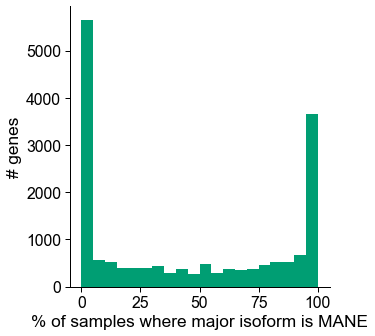

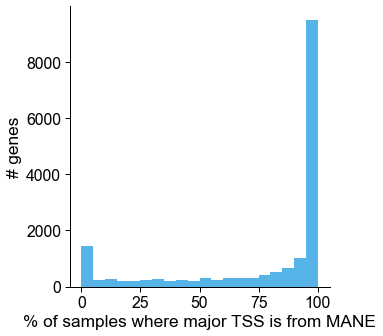

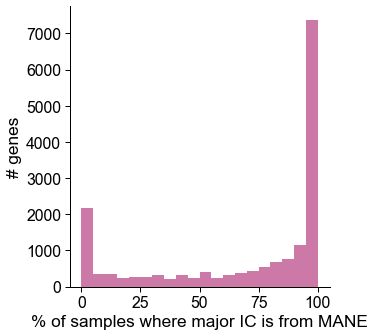

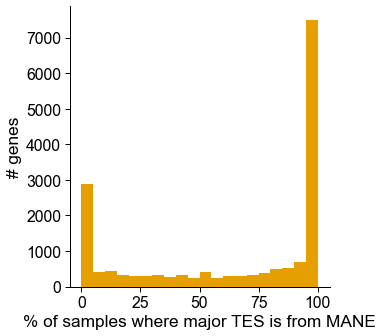

In [32]:
df = plot_major_principal_feat_counts(sg, opref='figures/',
                                      obs_col=obs_col,
                                      gene_subset=gene_subset)

In [33]:
df.to_csv('major_principal_feat_counts.tsv', sep='\t')

In [34]:
df.head()

,gname,gid_stable,tss,ic,tes,triplet,not_tss,not_ic,not_tes,not_triplet,n_samples,perc_triplet,perc_tss,perc_ic,perc_tes
0,A1BG,ENSG00000121410,2,2,24,0,42,42,20,44,44,0.000000,4.545455,4.545455,54.545455
1,A1CF,ENSG00000148584,10,0,1,0,0,10,9,10,10,0.000000,100.000000,0.000000,10.000000
2,A2M,ENSG00000175899,25,32,32,24,7,0,0,8,32,75.000000,78.125000,100.000000,100.000000
3,A2ML1,ENSG00000166535,0,0,0,0,3,3,3,3,3,0.000000,0.000000,0.000000,0.000000
4,A4GALT,ENSG00000128274,38,37,38,37,0,1,0,1,38,97.368421,100.000000,97.368421,100.000000


In [35]:
# what % of genes is MANE not used in all samples?
feats = ['triplet', 'tss', 'ic', 'tes']
for feat in feats:
    col = 'perc_{}'.format(feat)
    n = len(df.index)
    n_num = len(df.loc[df[col] != 100].index)
    print('{:.2f}% of genes ({}/{}) have >1 sample where most highly expressed {} is not from MANE'.format((n_num/n)*100,n_num,n,feat))

83.10% of genes (14099/16966) have >1 sample where most highly expressed triplet is not from MANE
51.91% of genes (8807/16966) have >1 sample where most highly expressed tss is not from MANE
65.05% of genes (11037/16966) have >1 sample where most highly expressed ic is not from MANE
60.75% of genes (10306/16966) have >1 sample where most highly expressed tes is not from MANE


In [37]:
temp = count_major_principal_feats(sg, obs_col=obs_col, gene_subset=gene_subset)


83.10% (14099/16966) genes with >= 1 sample where the major triplet is not MANE

51.91% (8807/16966) genes with >= 1 sample where the major tss is not MANE

65.05% (11037/16966) genes with >= 1 sample where the major ic is not MANE

60.75% (10306/16966) genes with >= 1 sample where the major tes is not MANE


In [38]:
get_major_principal_feats(sg, obs_col=obs_col, gene_subset=gene_subset)

16966
15120
ic
89.12% of genes have >=1 sample where major ic is MANE

16966
15696
tss
92.51% of genes have >=1 sample where major tss is MANE

16966
14585
tes
85.97% of genes have >=1 sample where major tes is MANE

16966
11928
triplet
70.31% of genes have >=1 sample where major triplet is MANE



,gname,gid_stable,tss,ic,tes,triplet
0,A1BG,ENSG00000121410,True,True,True,False
1,A1CF,ENSG00000148584,True,False,True,False
2,A2M,ENSG00000175899,True,True,True,True
3,A2ML1,ENSG00000166535,False,False,False,False
4,A4GALT,ENSG00000128274,True,True,True,True
...,...,...,...,...,...,...
16961,ZYG11A,ENSG00000203995,True,True,True,True
16962,ZYG11B,ENSG00000162378,True,True,True,True
16963,ZYX,ENSG00000159840,True,True,True,True
16964,ZZEF1,ENSG00000074755,True,False,False,False


## Expression of MANE isos vs. principal isos

In [218]:
sg, obs_col, gene_subset = get_data()
obs_col = 'sample'
min_tpm = 1
ca = cerberus.read(h5)
df = get_major_feats(sg, obs_col=obs_col, gene_subset=gene_subset, min_tpm=min_tpm)
df.to_csv('major_feats.tsv', sep='\t', index=False)

17629
Read in graph from swan.p
8779881
2529073

2281795
2281795

5297117
5297117

2774881
2774881



In [204]:
# df.loc[df.tss_tpm < df.triplet_tpm]
# # df['temp'] = df.gid+'_'+df['sample']
# # df.loc[df.temp.duplicated(keep=False)].sort_values('temp')

,tid,gid,sample,tid_pi,triplet_tpm,gid_stable,tss_id,tss_pi,tss_tpm,ic_id,...,ic_tpm,tes_id,tes_pi,tes_tpm,gname,tss,ic,tes,triplet,temp
170,"ENSG00000284713[2,2,2]",ENSG00000284713,k562,50.000000,1.355699,ENSG00000284713,ENSG00000284713_1,50.000000,0.677849,ENSG00000284713_2,...,1.355699,ENSG00000284713_2,100.000000,2.033548,SMIM38,1,2,2,"2,2,2",ENSG00000284713_k562
218,"ENSG00000284194[3,4,1]",ENSG00000284194,ovary,50.000000,1.135598,ENSG00000284194,ENSG00000284194_2,50.000000,0.660812,ENSG00000284194_3,...,0.660812,ENSG00000284194_1,100.000000,1.135598,SCO2,2,3,1,"3,4,1",ENSG00000284194_ovary
801,"ENSG00000278540[16,24,1]",ENSG00000278540,k562,45.121948,10.845590,ENSG00000278540,ENSG00000278540_2,50.000000,10.537878,ENSG00000278540_24,...,10.845590,ENSG00000278540_1,52.439022,11.523439,ACACA,2,24,1,"16,24,1",ENSG00000278540_k562
1667,"ENSG00000276644[2,4,2]",ENSG00000276644,h1_de,50.000000,1.024579,ENSG00000276644,ENSG00000276644_1,50.000000,0.980450,ENSG00000276644_1,...,0.980450,ENSG00000276644_1,50.000000,0.980450,DACH1,1,1,1,"2,4,2",ENSG00000276644_h1_de
3049,"ENSG00000273841[5,17,1]",ENSG00000273841,hl60_m0,42.857143,2.386973,ENSG00000273841,ENSG00000273841_1,42.857143,1.591315,ENSG00000273841_17,...,2.386973,ENSG00000273841_1,85.714287,3.978288,TAF9,1,17,1,"5,17,1",ENSG00000273841_hl60_m0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530028,"ENSG00000004487[11,18,1]",ENSG00000004487,hl60_m1_24hr,50.000000,6.021666,ENSG00000004487,ENSG00000004487_1,50.000000,4.671427,ENSG00000004487_18,...,6.021666,ENSG00000004487_1,100.000000,10.036110,KDM1A,1,18,1,"11,18,1",ENSG00000004487_hl60_m1_24hr
530394,"ENSG00000003756[19,35,1]",ENSG00000003756,hl60_m1_24hr,45.631069,54.499985,ENSG00000003756,ENSG00000003756_1,54.368931,49.828556,ENSG00000003756_35,...,54.499985,ENSG00000003756_1,78.640778,84.085686,RBM5,1,35,1,"19,35,1",ENSG00000003756_hl60_m1_24hr
530721,"ENSG00000003147[8,20,1]",ENSG00000003147,gm12878,41.904762,11.226151,ENSG00000003147,ENSG00000003147_9,54.285717,11.042939,ENSG00000003147_21,...,11.042939,ENSG00000003147_1,58.095242,13.720851,ICA1,9,21,1,"8,20,1",ENSG00000003147_gm12878
531613,"ENSG00000001084[1,1,1]",ENSG00000001084,hl60_m2_72hr,40.540539,9.083106,ENSG00000001084,ENSG00000001084_12,59.459461,8.026498,ENSG00000001084_16,...,8.026498,ENSG00000001084_1,59.459461,11.353883,GCLC,12,16,1,"1,1,1",ENSG00000001084_hl60_m2_72hr


In [207]:
tpm_df = swan.calc_tpm(sg.tss_adata, obs_col=obs_col, how='max')
tpm_df = tpm_df.sparse.to_dense()
tpm_df = tpm_df.T
tpm_df.loc['ENSG00000284713_2', 'k562']

1.3556987

In [217]:
temp = pd.read_csv('../cerberus_filtered_abundance.tsv', sep='\t')
c = [c for c in temp.columns if 'k562' in c]
temp_tss = temp.loc[temp

,gene_ID,transcript_ID,annot_gene_id,annot_transcript_id,annot_gene_name,annot_transcript_name,n_exons,length,gene_novelty,transcript_novelty,...,adrenal_gland_1_1,h1_de_1_1,heart_right_ventricle_3_1,right_cardiac_atrium_1_1,ovary_3_1,huvec_1_2,right_cardiac_atrium_4_1,wtc11_1_2,kidney_1_1,heart_left_ventricle_2_1
0,2,1150534,ENSG00000227232.5,"ENSG00000227232[1,2,1]",WASH7P,"WASH7P[1,2,1]",9.0,2065.0,Known,NIC,...,0,0,1,0,0,2,0,0,0,0
1,2,207076,ENSG00000227232.5,"ENSG00000227232[1,3,1]",WASH7P,"WASH7P[1,3,1]",10.0,1828.0,Known,NIC,...,0,0,2,0,0,1,0,1,2,1
2,2,207057,ENSG00000227232.5,"ENSG00000227232[1,4,1]",WASH7P,"WASH7P[1,4,1]",10.0,2164.0,Known,NIC,...,0,0,0,1,0,0,2,1,0,0
3,2,207067,ENSG00000227232.5,"ENSG00000227232[1,5,1]",WASH7P,"WASH7P[1,5,1]",11.0,1922.0,Known,NIC,...,0,0,2,2,1,1,2,1,2,0
4,2,1150534,ENSG00000227232.5,"ENSG00000227232[2,2,1]",WASH7P,"WASH7P[2,2,1]",9.0,2065.0,Known,NIC,...,0,0,0,0,0,0,0,0,0,0


In [215]:
# print(sg.adata.layers['counts'].sum())
# print(sg.tss_adata.layers['counts'].sum())
# print(sg.tes_adata.layers['counts'].sum())
# print(sg.ic_adata.layers['counts'].sum())

In [194]:
sg.tss_adata.layers

Layers with keys: counts, tpm, pi

In [183]:
df.head()

,tid,gid,sample,tid_pi,tpm_x,gid_stable,tss_id,tss_pi,tpm_y,ic_id,ic_pi,tpm_x,tes_id,tes_pi,tpm_y,gname,tss,ic,tes,triplet
0,"ENSG00000285043[5,15,1]",ENSG00000285043,wtc11,95.815292,286.627014,ENSG00000285043,ENSG00000285043_5,96.392494,288.419983,ENSG00000285043_15,96.825394,290.004364,ENSG00000285043_1,99.783554,298.055237,ENSG00000285043,5,15,1,"5,15,1"
1,"ENSG00000285043[5,15,1]",ENSG00000285043,vessels,92.857140,245.049713,ENSG00000285043,ENSG00000285043_5,93.095238,245.509506,ENSG00000285043_15,94.642860,248.072739,ENSG00000285043_1,100.000000,265.761627,ENSG00000285043,5,15,1,"5,15,1"
2,"ENSG00000285043[5,15,1]",ENSG00000285043,pgp1_excite_neuron,81.538460,50.147282,ENSG00000285043,ENSG00000285043_5,83.076927,51.165703,ENSG00000285043_15,81.538460,50.147282,ENSG00000285043_1,100.000000,61.547829,ENSG00000285043,5,15,1,"5,15,1"
3,"ENSG00000285043[5,15,1]",ENSG00000285043,pgp1_endo,80.000000,54.699585,ENSG00000285043,ENSG00000285043_5,80.000000,54.699585,ENSG00000285043_15,80.000000,54.699585,ENSG00000285043_1,100.000000,67.684586,ENSG00000285043,5,15,1,"5,15,1"
4,"ENSG00000285043[5,15,1]",ENSG00000285043,pgp1_astro,85.310730,155.122467,ENSG00000285043,ENSG00000285043_5,85.875710,155.955414,ENSG00000285043_15,85.310730,155.122467,ENSG00000285043_1,100.000000,180.300812,ENSG00000285043,5,15,1,"5,15,1"


In [157]:
df = pd.read_csv('major_feats.tsv', sep='\t')


feats = ['triplet', 'tss', 'ic', 'tes']
feats = ['triplet'] 
adata_dict = {'triplet': sg.adata, 'tss': sg.tss_adata,
              'ic': sg.ic_adata, 'tes': sg.tes_adata}

for feat in feats:
    
    if feat == 'triplet':
        col1 = 'tid'
        col2 = 'transcript_id'
        col3 = 'tid'
    elif feat == 'tss': 
        col3 = 'tss_id'
    elif feat == 'ic':
        col3 = 'ic_id'
    elif feat == 'tes': 
        col3 = 'tes_id'
    
    adata = adata_dict[feat]
    tpm_df = swan.calc_tpm(adata, obs_col=obs_col, how='max')
    tpm_df = tpm_df.sparse.to_dense()
    tpm_df = tpm_df.T
    
    tpm_df = tpm_df.melt(var_name='sample', value_name='tpm', ignore_index=False)
    tpm_df.reset_index(inplace=True)
    tpm_df.rename({'index': col1}, axis=1, inplace=True)
    tpm_df = tpm_df.loc[tpm_df.tpm >= min_tpm]

In [158]:
df = df.merge(tpm_df, how='left', on=[col3, 'sample'])

In [159]:
# get mane tids -- look at v40 metadata and cross ref. w/ cerberus
# also grab their TPMs
t_df = pd.read_csv('../../../refs/v40_transcript_metadata.tsv', sep='\t')
mane_tids = t_df.loc[t_df.MANE_Select].tid.tolist()
mane_df = ca.t_map.copy(deep=True)
mane_df = mane_df.loc[mane_df.source=='v40']
mane_df = mane_df.loc[mane_df.original_transcript_id.isin(mane_tids)]
mane_feats = mane_df[col2].unique().tolist()

In [160]:
mane_df = tpm_df.loc[tpm_df.tid.isin(mane_feats)]
mane_df['gid'] = mane_df.tid.str.split('[', expand=True)[0]

In [161]:
df = df.merge(mane_df, on=['gid', 'sample'], how='left', suffixes=('_principal', '_mane'))

In [162]:
df['mane_principal'] = df.tid_mane == df.tid_principal

In [163]:
df.loc[df.tid_mane.isnull()].head()

,tid_principal,gid,sample,tid_pi,gid_stable,tss_id,tss_pi,ic_id,ic_pi,tes_id,tes_pi,gname,tss,ic,tes,triplet,tpm_principal,tid_mane,tpm_mane,mane_principal
3,"ENSG00000285043[5,15,1]",ENSG00000285043,pgp1_endo,80.00000,ENSG00000285043,ENSG00000285043_5,80.00000,ENSG00000285043_15,80.0000,ENSG00000285043_1,100.000000,ENSG00000285043,5,15,1,"5,15,1",54.699585,NaN,NaN,False
5,"ENSG00000285043[5,15,1]",ENSG00000285043,pgp1,96.87500,ENSG00000285043,ENSG00000285043_5,96.87500,ENSG00000285043_15,96.8750,ENSG00000285043_1,100.000000,ENSG00000285043,5,15,1,"5,15,1",201.991425,NaN,NaN,False
7,"ENSG00000285043[5,15,1]",ENSG00000285043,pc3,95.23810,ENSG00000285043,ENSG00000285043_5,95.23810,ENSG00000285043_15,95.2381,ENSG00000285043_1,100.000000,ENSG00000285043,5,15,1,"5,15,1",192.524796,NaN,NaN,False
8,"ENSG00000285043[5,15,1]",ENSG00000285043,panc1,76.61290,ENSG00000285043,ENSG00000285043_5,76.61290,ENSG00000285043_15,76.6129,ENSG00000285043_1,100.000000,ENSG00000285043,5,15,1,"5,15,1",96.123878,NaN,NaN,False
11,"ENSG00000285043[5,15,1]",ENSG00000285043,muscle,95.86777,ENSG00000285043,ENSG00000285043_5,96.16829,ENSG00000285043_15,95.9429,ENSG00000285043_1,99.924866,ENSG00000285043,5,15,1,"5,15,1",860.954773,NaN,NaN,False


In [173]:
# number of gene / sample combinations where MANE isoform
# is expressed but NOT the principal isoform
temp = df.loc[df.mane_principal == False].copy(deep=True) # mane != principal
len(temp.loc[temp.triplet == '1,1,1'].index) # principal != mane


27135

In [168]:
# t_df = pd.read_csv('../../../refs/v40_transcript_metadata.tsv', sep='\t')
# t_df = t_df.loc[t_df.MANE_Select]
# t_df.loc[t_df.gid.str.contains('ENSG00000285043')]